# Loading the Model And Setup

In [ ]:
%%capture
!git clone https://github.com/Lyleregenwetter/2155-Challenge-Problem-3
!pip install torchmetrics
%cd 2155-Challenge-Problem-3/

import utils

import numpy as np
import torch
from huggingface_hub import snapshot_download
import sys
from pathlib import Path
from tqdm.auto import tqdm, trange

# Download the bikefusion repository
repo_dir = snapshot_download("ahn1376/bikefusion",local_dir="./bikefusion")

import bikefusion

In [ ]:
# Load the model
Diffuser = bikefusion.load_bikefusion()

Some utility functions

In [ ]:
def combine_orig_and_pred(masked_images, predicted_images, masks):
    combination = predicted_images*masks + masked_images*(1-masks)
    return combination

def get_mask_channel(images, masks):
    # Create an empty mask channel with the same spatial dimensions
    mask_channel = np.zeros((images.shape[0], images.shape[2], images.shape[3]))

    # Populate the mask channel based on the coordinates in masks
    for i in trange(masks.shape[0]):
        mask_channel[i, masks[i][3]:masks[i][1], masks[i][0]:masks[i][2]] = 1.0

    return mask_channel

## Running on The Test Data

A few common mistakes I have seen:

1. ***Don't Imaging Features Without Confirming Them:*** The `get_sample_batch` function in bikefusion does not have anything with `'test'` so if you pass this as split variable it will just give you samples from training because that is what it falls back to.
2. ***Image Pixel Values Are Ranged From -1 to 1 In Diffusion:***: I see many cases of students combining images without taking this into account. This will break your pixel color values!

Below is how you can run the model on the test data and make a submission:

In [ ]:
# You have to first load the test data (THIS IS NOT IN DEMO SEE THE CP NOTEBOOK)
partial_images, masks, parametric, description, targets  = utils.load_data(split="test")

# See that images are None and ground truth is not provided hence the challenge
print(f"Masked images: array with shape: {partial_images.shape}")
print(f"Masks: array with shape: {masks.shape}")
print(f"Parametric: array with shape: {parametric.shape}")
print(f"Description: list with length: {len(description)}")
print(f"Images: array with shape: {targets}")

First we must process these to be suitable for diffusion model input:

In [ ]:
test_partials = bikefusion.preprocess(partial_images)

In [ ]:
mask_maps = get_mask_channel(partial_images, masks)[:, None, :, :]

In [ ]:
# get a random set of images from our training set
n = 8
idx = np.random.choice(len(test_partials), n, replace=False)

# plot the images
bikefusion.visualize_imagesets(partial_images[idx],
                    mask_maps[idx],
                    titles=["Masked Image", "Mask Map"])

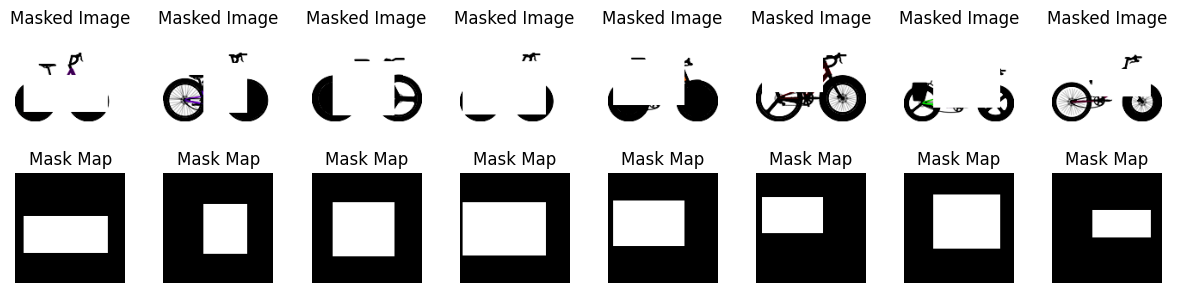

In [13]:
# we need to fill the masks too
mask_maps_test = (1-bikefusion.preprocess(255*(1-mask_maps)))/2

bikefusion.visualize_imagesets(test_partials[idx],
                    mask_maps_test[idx],
                    titles=["Masked Image", "Mask Map"])

(array([  1.,   0.,   1.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   2.,   2.,   1.,   1.,   4.,   0.,   2.,   2.,
          0.,   1.,   2.,   0.,   0.,   2.,   1.,   0.,   2.,   1.,   2.,
          1.,   0.,   1.,   1.,   2.,   0.,   0.,   0.,   0.,   1.,   1.,
          0.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   0., 109.,   2.,
          0.,   3.,   1.,   1.,   1.,   1.,   4.,   2.,   0.,   3.,   1.,
          1.,   1.,   1.,   1.,   1.,   2.,   2.,   1.,   3.,   1.,   0.,
          0.,   1.,   0.,   4.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   2.,   3.,   1.,   1.,   1.,   0.,   2.,   0.,   0.,   1.,
          1.]),
 array([315.17828845, 319.26083279, 323.34337714, 327.42592149,
        331.50846583, 335.59101018, 339.67355453, 343.75609887,
        347.83864322, 351.92118757, 356.00373191, 360.08627626,
        364.1688206 , 368.25136495, 372.3339093 , 376.41645364,
        380.49899799, 384.58154234, 388.66408668, 392.74663103

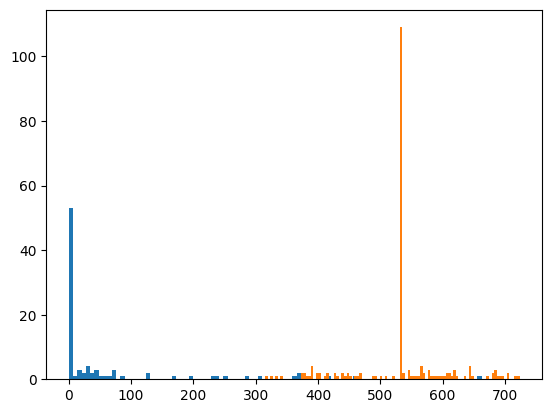

In [14]:
#Lets try and make a new guidance function with the parametric data
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

imp = SimpleImputer(missing_values = np.nan, strategy = "mean")
param_imp = imp.fit_transform(parametric)

plt.hist(param_imp[0].flatten(), bins=100) #Plot different values in first parameter collection
plt.hist(param_imp[:200,0].flatten(), bins=100) #Plot all values of first feature

In [15]:
#Failed Test: Hybrid U-Net and DNN
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import nn
from torch.nn import functional as F
from torch.optim import AdamW

from torchsummary import summary

from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        # Define fully connected layers
        self.fc1 = nn.Linear(96, 128)  # Input size is 96, output size is 128
        self.fc2 = nn.Linear(128, 256)       # 128 inputs, 256 outputs
        self.fc3 = nn.Linear(256, 512)        # 256 inputs, 512 outputs

    def forward(self, x): # Call all the layers in this function
        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))  # [batch x 64]
        x = F.relu(self.fc2(x))  # [batch x 64]

        # Output layer (no activation for final regression layer)
        x = self.fc3(x)  # [batch x 512]
        return x

model_dnn = DNN()
model_dnn.to(device)
print(param_imp.shape)

(1000, 96)


Now we can generate images using both guidance and conditioning. This will be our baseline.

In [ ]:
from gensim.models import KeyedVectors
from huggingface_hub import hf_hub_download
w2v_model = KeyedVectors.load_word2vec_format(hf_hub_download(repo_id="Word2vec/nlpl_223", filename="model.bin"), binary=True, unicode_errors="ignore")

from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO
import random
from random import randint

model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

batch_size = 32
n_batches = (len(test_partials) + batch_size - 1) // batch_size

inpaintings = []

for i in trange(n_batches):
    # First get the current batch of partial images from the test set
    masked_samples_tens = torch.tensor(test_partials[i*batch_size:(i+1)*batch_size]).to(Diffuser.device)
    sample_masks_tens = torch.tensor(mask_maps_test[i*batch_size:(i+1)*batch_size]).to(Diffuser.device)
    #Get current batch of desctiptions
    sample_descriptions = description[i*batch_size:(i+1)*batch_size]

    current_batch_size = masked_samples_tens.shape[0]

    # define The guidance objective for this bactch
    def sample_guidance(denoised_images, timestep): #Calculates said error
        #Image Error
        un_masked_portion = denoised_images*((1-sample_masks_tens)==1) + sample_masks_tens
        image_error = torch.log(torch.cosh(masked_samples_tens - un_masked_portion)).sum() #Using log-cosh loss

        #Text Error
        denoised_post = bikefusion.postprocess(denoised_images)
        sum_similarities = 0

        for i in range(0,current_batch_size, randint(1,5)): #The randint step size was added due to time and computational constraints
          images_processed = processor(text=None,images=[denoised_post[i]],return_tensors='pt')['pixel_values']
          images_emb = clip_model.get_image_features(images_processed)

          text_processed = processor(text=[sample_descriptions[i]],images=None,return_tensors='pt', truncation=True, max_length=77)['input_ids']
          text_emb = clip_model.get_text_features(text_processed)

          similarity = torch.nn.functional.cosine_similarity(text_emb, images_emb, dim=1)
          sum_similarities += similarity.item()

        text_error = torch.tensor([1 - sum_similarities / batch_size]).to(Diffuser.device)

        error = image_error + text_error
        return error

    infilled = Diffuser.generate(masked_samples_tens, num_inference_steps=8, guidance_function=sample_guidance, guidance_scale=0.1) #Changed num_inference_steps and guidance_scale

    inpaintings.append(infilled)

  0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-31-40faddab4ac5>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masked_samples_tens = torch.tensor(test_partials[i*batch_size:(i+1)*batch_size]).to(Diffuser.device)
<ipython-input-31-40faddab4ac5>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_masks_tens = torch.tensor(mask_maps_test[i*batch_size:(i+1)*batch_size]).to(Diffuser.device)


  0%|          | 0/8 [00:00<?, ?it/s]

  3%|▎         | 1/32 [01:36<50:06, 96.99s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

  6%|▋         | 2/32 [03:02<45:11, 90.39s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

  9%|▉         | 3/32 [04:29<42:52, 88.69s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 4/32 [05:53<40:34, 86.95s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

 16%|█▌        | 5/32 [07:08<37:10, 82.61s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

 19%|█▉        | 6/32 [08:29<35:33, 82.06s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

 22%|██▏       | 7/32 [10:20<38:06, 91.46s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 8/32 [11:56<37:10, 92.95s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

 28%|██▊       | 9/32 [13:32<36:00, 93.93s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

 31%|███▏      | 10/32 [14:50<32:39, 89.06s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

 34%|███▍      | 11/32 [16:32<32:30, 92.87s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 12/32 [17:58<30:17, 90.88s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

 41%|████      | 13/32 [19:22<28:05, 88.70s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

 44%|████▍     | 14/32 [21:02<27:38, 92.13s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

 47%|████▋     | 15/32 [22:26<25:24, 89.67s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

 50%|█████     | 16/32 [23:59<24:13, 90.86s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

 53%|█████▎    | 17/32 [25:26<22:22, 89.49s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

 56%|█████▋    | 18/32 [27:14<22:13, 95.24s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

 59%|█████▉    | 19/32 [28:41<20:04, 92.64s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 20/32 [30:20<18:54, 94.55s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

 66%|██████▌   | 21/32 [31:42<16:37, 90.66s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

 69%|██████▉   | 22/32 [32:57<14:20, 86.10s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
# concatenate all of the genearated inpaintings
inpaintings = np.concatenate(inpaintings, axis=0)

Let's visualize our completions:

In [ ]:
n = 8
idx = np.random.choice(len(inpaintings), n, replace=False)

# plot the images
bikefusion.visualize_imagesets((test_partials[idx]+1)/2,
                    mask_maps_test[idx],
                    (inpaintings[idx]+1)/2,
                    titles=["Masked Image", "Mask Map", "In-Painted Image"])

In [ ]:
final_images = (mask_maps_test) * inpaintings + test_partials * (1-mask_maps_test) # keep original masked images exactly

final_images = bikefusion.postprocess(final_images) # Now this is ready for submission

np.save("submission2.npy",final_images) # Note this will be saved in 2155-Challenge-Problem-3/ directory

In [ ]:
# plot some sample images after post processing
n = 8
idx = np.random.choice(len(final_images), n, replace=False)

# plot the images
bikefusion.visualize_imagesets(partial_images[idx], final_images[idx], titles=["Masked Images", "In-Painted Image"])

In [ ]:
#Lets test out how using the text data can help! We can implement this similarity score into our guidance function.
from gensim.models import KeyedVectors
from huggingface_hub import hf_hub_download
w2v_model = KeyedVectors.load_word2vec_format(hf_hub_download(repo_id="Word2vec/nlpl_223", filename="model.bin"), binary=True, unicode_errors="ignore")

from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO

model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

sampled_values = np.random.choice(final_images.shape[0], size=100, replace=False)
final_sampled = final_images[sampled_values]
description_sampled = [description[i] for i in sampled_values]

similarities = []

for i in range(final_sampled.shape[0]):
  print(i)
  images_processed = processor(text=None,images=[final_sampled[i]],return_tensors='pt')['pixel_values']
  images_emb = clip_model.get_image_features(images_processed)
  #print(f"Embedding shape: {images_emb.shape}, data structure: {type(images_emb)} of type {images_emb.dtype}")

  text_processed = processor(text=[description_sampled[i]],images=None,return_tensors='pt', truncation=True, max_length=77)['input_ids']
  text_emb = clip_model.get_text_features(text_processed)
  #print(f"Embedding shape: {text_emb.shape}, data structure: {type(text_emb)} of type {text_emb.dtype}")

  similarity = torch.nn.functional.cosine_similarity(text_emb, images_emb, dim=1)
  #print(f"Similarity between image and accurate text prompt: {similarity.item()}")
  similarities.append(similarity)

print(sum(similarities)/len(similarities))